In [2]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
#from rdkit.Chem import rdPathUtilities
from rdkit.Chem import rdMolTransforms

In [56]:
def morgan_fingerprint(mol, radius=4, nbits=2048, nbits_3D=256):
    """
    Generates a morgan like 3D fingerprint for a molecule given its mol structure.
    
    Parameters:
    - mol : mol rdkit stuct representing the molecule
    - radius (int): radius parameter for the 3D fingerprint
    - nbits (int): number of bits in the 3D fingerprint
    
    Returns:
    - fingerprint (numpy.ndarray): binary vector representing the 3D fingerprint
    """
    mol = Chem.AddHs(mol)
    
    ''' 
    try:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)
    except:
        mol = mol1
    '''
    # Convert mol object to molecular graph
    graph = mol_to_graph(mol)
    
    # Initialize fingerprint vector
    fingerprint_part1 = np.zeros(nbits - nbits_3D, dtype=np.int8)
    fingerprint_part2 = np.zeros(nbits_3D, dtype=np.int8)
    
    # Iterate over atoms in the graph
    for i in range(len(graph)):
        # Generate circular substructures around the atom up to the specified radius
        substructures = generate_substructures(graph, i, radius)
        
        # Assign a unique identifier to each circular substructure using a hash function
        substructure_ids = [hash_substructure(substructure, mol) for substructure in substructures]
        substructure_ids_3D = []
        for substructure in substructures:
            if len(substructure) == 3:
                substructure_ids_3D.append(hash_substructure_3plus(substructure, mol))
            if len(substructure) == 4:
                substructure_ids_3D.append(hash_substructure_3plus(substructure, mol))
                
        # Add the substructure identifiers to the fingerprint vector
        for substructure_id in substructure_ids:
            fingerprint_part1[substructure_id % (nbits - nbits_3D)] = 1
        for substructure_id in substructure_ids_3D:
            fingerprint_part2[substructure_id % nbits_3D] = 1
            
        fingerprint = np.concatenate((fingerprint_part1, fingerprint_part2), axis=0)
    return fingerprint


def mol_to_graph(mol):
    """
    Number all atoms canonicaly
    
    Returns:
    - graph (list): list of lists representing the molecular graph
      Each sub-list contains the indices of the atoms bonded to the corresponding atom
    """
    
    # Assign explicit indices to the atoms manually
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(i)
    
    # Create the graph as a list of lists
    graph = [[] for _ in range(mol.GetNumAtoms())]
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        graph[i].append(j)
        graph[j].append(i)

    return graph


def generate_substructures(graph, atom_idx, radius):
    """
    Generates circular substructures around an atom up to the specified radius.
    
    Returns:
    - substructures (list): list of tuples representing the circular substructures
      Each tuple contains the indices of the atoms and bonds within the substructure
    """
    substructures = [(atom_idx,)]
    for r in range(1, radius + 1):
        substructures_r = []
        for substructure in substructures:            
            for neighbor in graph[substructure[-1]]:
                if neighbor not in substructure:
                    substructures_r.append(substructure + (neighbor,))
        substructures.extend(substructures_r)
    return substructures


def get_substruct_atom_nums(mol, substructure):
    # Use RDKit to get atomic numbers
    atm_numbers = []
    for atom_index in substructure:
        atom = mol.GetAtomWithIdx(atom_index)
        atm_numbers.append(atom.GetAtomicNum())
        
    return atm_numbers


def calc_bond_angle(mol, substructure):  
    # Use RDKit to calculate the bond angle
    angle = rdMolTransforms.GetAngleDeg(mol.GetConformer(), substructure[0], substructure[1],substructure[2])   
    
    return angle

def calc_dihedral_angle(mol, substructure):  
    # Calculate dihedral angle
    dihedral = rdMolTransforms.GetDihedralDeg(mol.GetConformer(), substructure[0], 
                                              substructure[1], substructure[2], substructure[3])
        
    return dihedral



def hash_substructure(substructure, mol):
    """
    Assigns a unique integer identifier to a circular substructure using a hash function.
    
    Returns:
    - substructure_id (int): integer identifier for the substructure
    """
    atm_numbers = get_substruct_atom_nums(mol, substructure)
    is_in_ring = mol.GetAtomWithIdx(substructure[0]).IsInRing()
    substructure_str = "-".join([str(i) for i in atm_numbers]) #substructure
    if is_in_ring:
        substructure_str += '-R'
    substructure_hash = hash(substructure_str)
    #print(substructure_str, substructure_hash)
    return substructure_hash


def hash_substructure_3plus(substructure, mol ):
    """
    Assigns a unique integer identifier to a circular substructure using a hash function.
    
    Returns:
    - substructure_id (int): integer identifier for the substructure
    """
    atm_numbers = get_substruct_atom_nums(mol, substructure)
    substructure_str = "-".join([str(i) for i in atm_numbers]) #substructure
    if len(substructure) >= 3:
        angle = calc_bond_angle(mol, substructure)        
        substructure_str += ':' + str(int(angle))
    if len(substructure) == 4:
        dihedral = calc_dihedral_angle(mol, substructure)        
        substructure_str += '::' + str(int(dihedral))
    substructure_hash = hash(substructure_str)
    # print(substructure_str, substructure_hash)
    return substructure_hash


def has_cycle(graph):
    """
    Walks through the graph in DFS manner
    
    Returns:
    -  (bool): bool value whether node is in cycle or not
    """ 
    visited = set()
    
    # Define the DFS function
    def dfs(node, parent):
        # Mark the current node as visited
        visited.add(node)
        
        # Iterate over the neighbors of the current node
        for neighbor in graph[node]:
            # If the neighbor has not been visited yet, recursively call DFS
            if neighbor not in visited:
                # If the recursive call returns True, it means a cycle has been found
                if dfs(neighbor, node):
                    return True
            # If the neighbor has been visited, but it is not the parent of the current node, a cycle has been found
            elif neighbor != parent:
                return True
            
    # Iterate over all nodes in the graph
    for node in graph:
        if node not in visited:
            if dfs(node, None):
                return True
    
    return False


In [392]:
# Calculate the Jaccard distance
jaccard_dist = 1.0 - np.sum(np.minimum(fps_conf[0], fps_conf[1])) / np.sum(np.maximum(fps_conf[0], fps_conf[1]))

print("Jaccard distance between the two arrays is:", jaccard_dist)

Jaccard distance between the two arrays is: 0.0


In [11]:
# Define the SMILES strings
smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
smiles1 = 'Cc1ccccc1C(=O)O'
smiles2 = 'Cc1ccc(C(=O)O)cc1'

# Vitamin A experiment
smiles1 = 'CC(=CC=CC(C)=CCO)C=CC1=C(C)CCCC1(C)C'
smiles2 = 'CC(=CC=CCO)C=CC=C(C)C=CC1=C(C)CCCC1(C)C'

# Create RDKit molecules from the SMILES strings
mol1 = Chem.MolFromSmiles(smiles1)
AllChem.EmbedMolecule(mol1)
AllChem.UFFOptimizeMolecule(mol1)
mol1.GetConformer()

mol2 = Chem.MolFromSmiles(smiles2)
AllChem.EmbedMolecule(mol2)
AllChem.UFFOptimizeMolecule(mol2)
mol2.GetConformer()

# Generate my version of morgan 3D fingerprint
fp1 = morgan_fingerprint(mol1, nbits=64, nbits_3D=10)
fp2 = morgan_fingerprint(mol2, nbits=64, nbits_3D=10)

fp1, fp2

[12:23:28] Molecule does not have explicit Hs. Consider calling AddHs()
[12:23:28] Molecule does not have explicit Hs. Consider calling AddHs()
[12:23:28] Molecule does not have explicit Hs. Consider calling AddHs()
[12:23:28] Molecule does not have explicit Hs. Consider calling AddHs()


(array([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=int8),
 array([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=int8))

In [12]:
# Calculate the Jaccard distance
jaccard_dist = 1.0 - np.sum(np.minimum(fp1, fp2)) / np.sum(np.maximum(fp1, fp2))

print("Jaccard distance between the two arrays is:", jaccard_dist)

Jaccard distance between the two arrays is: 0.021276595744680882


# LXRB dataset

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from rdkit.Chem import PandasTools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

path = '/home/clarovak/work/ds/VDR_conformations/'
file = '3KPZ_VDR_actives_decoys_dock_CHEMPLP_2.sdf'
df_confs = PandasTools.LoadSDF(path+'1DB1_CHEMPLP_docked_VDRML_conf_LMD.sdf')

,id_conf,ID,ROMol
0,VDRML1546_4,1546_4_entry_00004_conf_01,
1,VDRML5893_53,5893_53_entry_00053_conf_01,
2,VDRML1546_16,1546_16_entry_00016_conf_01,
3,VDRML1549_25,1549_25_entry_00025_conf_01,
4,VDRML7446_56,7446_56_entry_00056_conf_01,
...,...,...,...
40765,VDRML19748_23,19748_23_entry_00023_conf_01,
40766,VDRML1781_2,1781_2_entry_00002_conf_01,
40767,VDRML2788_2,2788_2_entry_00002_conf_01,
40768,VDRML6089_15,6089_15_entry_00015_conf_01,

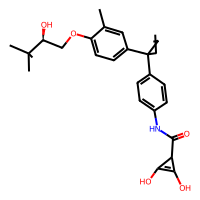
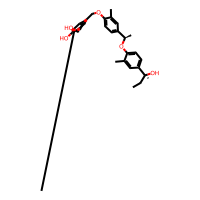
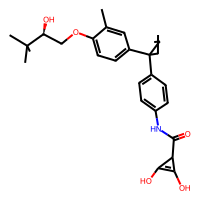
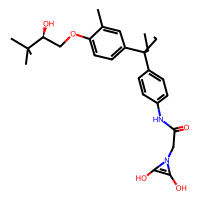
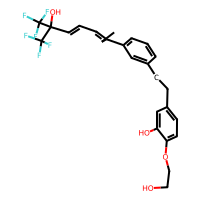
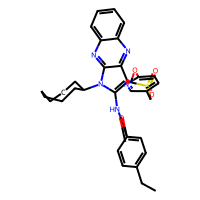
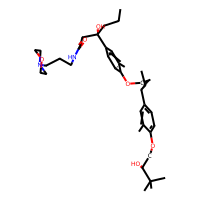
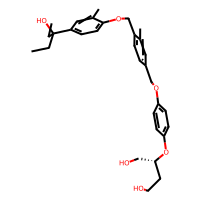
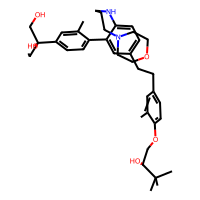
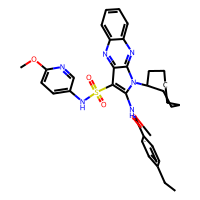

In [14]:

df_confs

In [5]:

df_scores = pd.read_csv(path+'VDR_VDRML_ECR_plus_docking_results_plus_rank_1DB1_3KPZ_conformations_new.csv')
df_merged = pd.merge(df_confs, df_scores, on='id_conf')

In [33]:
df_contains = df_confs[df_confs.id_conf.str.contains('VDRML13066')]
df_contains

,id_conf,ID,ROMol
16,VDRML13066_14,13066_14_entry_00014_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd847a50>
4638,VDRML13066_17,13066_17_entry_00017_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd5580b0>
8893,VDRML13066_12,13066_12_entry_00012_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd2c83c0>
17257,VDRML13066_63,13066_63_entry_00063_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fce11890>


### Proper train test split by id

In [57]:
df_merged['id_train'] = df_merged.id_conf.map(lambda x: x.split('_')[0])

# drop duplicated to avoid data leak
df_droped = df_merged.drop_duplicates('id_train')
print(df_droped.shape)

# sample df_droped to make dataset smaller
df_droped = df_droped.sample(n=7000, random_state=0)
print(df_droped.shape)

(14375, 29)
(7000, 29)


In [58]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_droped.id_train, 
                                                    df_droped.docking_score_CHEMPLP_1DB1, 
                                                    test_size=0.2, random_state=0)

len(X_train), len(X_test)

(5600, 1400)

In [59]:
# select rows based on the ids in the list and keep only first three duplicates
df_train = df_merged[df_merged['id_train'].isin(X_train)]
df_test = df_merged[df_merged['id_train'].isin(X_test)]

df_train = df_train.groupby('id_train').head(3)
df_test = df_test.groupby('id_train').head(3)
print(df_train.shape, df_test.shape)
df_train.head()

(13001, 29) (3238, 29)


,id_conf,ID,ROMol,smiles,ECR_1DB1,ECR_3KPZ,docking_score_CHEMPLP_1DB1,rank_CHEMPLP_1DB1,docking_score_CHEMPLP_3KPZ,rank_CHEMPLP_3KPZ,...,rank_AHB_1DB1,docking_score_AHB_3KPZ,rank_AHB_3KPZ,docking_score_AdG_1DB1,rank_AdG_1DB1,docking_score_AdG_3KPZ,rank_AdG_3KPZ,ECR_1DB1_new,ECR_3KPZ_new,id_train
6,VDRML1551_20,1551_20_entry_00020_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd8475f0>,O(CC(O)C(C)(C)C)c1ccc(cc1C)C(CC)(CO)c1ccc(NC(=...,0.049659,9.148893e-02,-122.372,3808,-14.4290,33669,...,125,-140.73193,46,-8.031265,3226,-7.426530,5351,0.005024,5.056454e-03,VDRML1551
9,VDRML6796_19,6796_19_entry_00019_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd847740>,FC(C(O)COCc1cc(ccc1)C(CC)(CC)c1ccc(OC(CCO)CO)c...,0.036788,3.565504e-222,-127.804,1340,-17.6693,18987,...,6704,-107.87830,5508,-2.596805,29078,-4.403986,23748,0.002692,4.200279e-09,VDRML6796
10,VDRML10738_9,10738_9_entry_00009_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd8477b0>,O(C(CCC(O)c1cc(C)c(OCC(O)C(C)(C)C)cc1)CO)c1ccc...,0.033287,7.427358e-03,-109.836,13151,-17.5072,20044,...,205,-119.17574,1640,-8.271292,2631,-5.877480,14981,0.004164,2.541324e-03,VDRML10738
14,VDRML5220_29,5220_29_entry_00029_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd847970>,Clc1c(cccc1OCc1cc(CO)c(cc1)CO)C(CC)=CC(CC(O)(C...,0.026389,7.401164e-79,-121.680,4274,-11.0556,38504,...,131,-118.50873,1776,-11.938198,32,-8.108592,3054,0.006939,3.154054e-05,VDRML5220
16,VDRML13066_14,13066_14_entry_00014_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd847a50>,FC(F)(F)C(O)(C=CC=Cc1cc(ccc1)C(CC)(CC)c1cc(C)c...,0.018296,5.004514e-05,-122.611,3665,-18.5351,11578,...,82,-138.48085,76,-9.625269,674,-9.305398,896,0.005164,2.679589e-03,VDRML13066


### Let's train a model for each of the scores

In [60]:
score_names = [col for col in df_train.columns if 'docking' in col]
X_fps_train = [morgan_fingerprint(mol, nbits=(2048), nbits_3D=256) for mol in df_train.ROMol]
X_fps_test =[morgan_fingerprint(mol, nbits=(2048), nbits_3D=256) for mol in df_test.ROMol]

In [126]:
preds_df = pd.DataFrame()
res_metrics = []
for name in score_names:
    print(name)
    model = XGBRegressor()
    y_train = df_train[name]
    model.fit(X_fps_train, y_train)
    y_test = df_test[name]
    y_pred = model.predict(X_fps_test)
    preds_df[name] = y_test
    preds_df['preds_'+'name'] = y_pred

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    res_metrics.append([mse, mae, r2])
    # Print evaluation metrics
    print('Mean Squared Error: ', mse)
    print('Mean Absolute Error: ', mae)
    print('R-squared: ', r2)

docking_score_CHEMPLP_1DB1
Mean Squared Error:  74.95813568756283
Mean Absolute Error:  6.713120603578601
R-squared:  0.7828264411712402
docking_score_CHEMPLP_3KPZ
Mean Squared Error:  5.68029568026282
Mean Absolute Error:  1.6054614187509324
R-squared:  0.38805021614157753
docking_score_london_1DB1
Mean Squared Error:  1.6248706000046593
Mean Absolute Error:  0.9650141000890723
R-squared:  0.3967572954673536
docking_score_london_3KPZ
Mean Squared Error:  1.8327102694452795
Mean Absolute Error:  1.005385874722697
R-squared:  0.35345281494826253
docking_score_ASE_1DB1
Mean Squared Error:  5.5034274486839925
Mean Absolute Error:  1.797989034788795
R-squared:  0.816976858020523
docking_score_ASE_3KPZ
Mean Squared Error:  5.33878686008267
Mean Absolute Error:  1.7780658396615214
R-squared:  0.8148177684012514
docking_score_AHB_1DB1
Mean Squared Error:  200.85709962881702
Mean Absolute Error:  10.486625307468639
R-squared:  0.29390170530320525
docking_score_AHB_3KPZ
Mean Squared Error:  202

<AxesSubplot: xlabel='docking_score_AdG_3KPZ'>

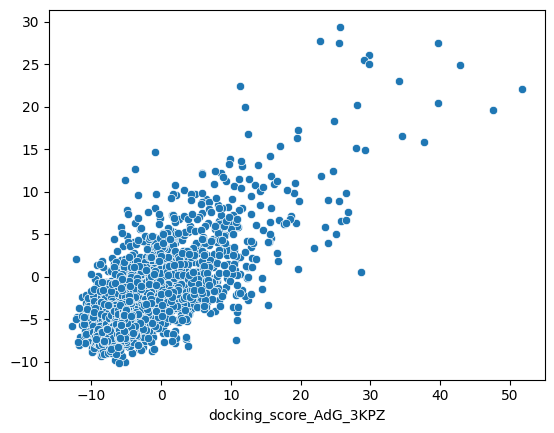

In [115]:
preds_df.to_csv('predicted_myfps_3D2048+512.csv', index=False)
sns.scatterplot(x=y_test,y=y_pred)

### Let's look how does those conformers look

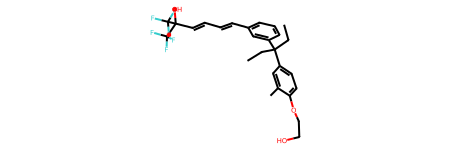

In [39]:
df_contains.ROMol.to_list()[0]

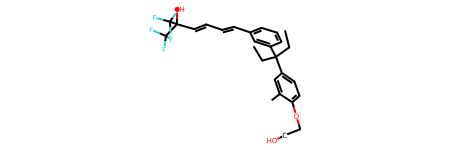

In [40]:
df_contains.ROMol.to_list()[1]

In [44]:
conformers_myfps = [morgan_fingerprint(mol, nbits=(2048), nbits_3D=128) for mol in df_contains.ROMol]
# Calculate the Jaccard distance
jaccard_dist = 1.0 - np.sum(np.minimum(conformers_myfps[0], conformers_myfps[1])) / np.sum(np.maximum(conformers_myfps[0], conformers_myfps[1]))

print("Jaccard distance between the two arrays is:", jaccard_dist)

Jaccard distance between the two arrays is: 0.04035874439461884


In [45]:
conformers_myfps[0][-128:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [46]:
conformers_myfps[1][-128:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

### Morgan FPS

In [50]:
# select rows based on the ids in the list and keep only first duplicate

df_train_one_dupl = df_merged[df_merged['id_train'].isin(X_train)]
df_test_one_dupl = df_merged[df_merged['id_train'].isin(X_test)]

df_train_one_dupl = df_train_one_dupl.groupby('id_train').head(1)
df_test_one_dupl = df_test_one_dupl.groupby('id_train').head(1)
print(df_train_one_dupl.shape, df_test_one_dupl.shape)
df_train_one_dupl.head()

(5600, 29) (1400, 29)


,id_conf,ID,ROMol,smiles,ECR_1DB1,ECR_3KPZ,docking_score_CHEMPLP_1DB1,rank_CHEMPLP_1DB1,docking_score_CHEMPLP_3KPZ,rank_CHEMPLP_3KPZ,...,rank_AHB_1DB1,docking_score_AHB_3KPZ,rank_AHB_3KPZ,docking_score_AdG_1DB1,rank_AdG_1DB1,docking_score_AdG_3KPZ,rank_AdG_3KPZ,ECR_1DB1_new,ECR_3KPZ_new,id_train
6,VDRML1551_20,1551_20_entry_00020_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd8475f0>,O(CC(O)C(C)(C)C)c1ccc(cc1C)C(CC)(CO)c1ccc(NC(=...,0.049659,9.148893e-02,-122.372,3808,-14.4290,33669,...,125,-140.73193,46,-8.031265,3226,-7.426530,5351,0.005024,5.056454e-03,VDRML1551
9,VDRML6796_19,6796_19_entry_00019_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd847740>,FC(C(O)COCc1cc(ccc1)C(CC)(CC)c1ccc(OC(CCO)CO)c...,0.036788,3.565504e-222,-127.804,1340,-17.6693,18987,...,6704,-107.87830,5508,-2.596805,29078,-4.403986,23748,0.002692,4.200279e-09,VDRML6796
10,VDRML10738_9,10738_9_entry_00009_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd8477b0>,O(C(CCC(O)c1cc(C)c(OCC(O)C(C)(C)C)cc1)CO)c1ccc...,0.033287,7.427358e-03,-109.836,13151,-17.5072,20044,...,205,-119.17574,1640,-8.271292,2631,-5.877480,14981,0.004164,2.541324e-03,VDRML10738
14,VDRML5220_29,5220_29_entry_00029_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd847970>,Clc1c(cccc1OCc1cc(CO)c(cc1)CO)C(CC)=CC(CC(O)(C...,0.026389,7.401164e-79,-121.680,4274,-11.0556,38504,...,131,-118.50873,1776,-11.938198,32,-8.108592,3054,0.006939,3.154054e-05,VDRML5220
16,VDRML13066_14,13066_14_entry_00014_conf_01,<rdkit.Chem.rdchem.Mol object at 0x7f55fd847a50>,FC(F)(F)C(O)(C=CC=Cc1cc(ccc1)C(CC)(CC)c1cc(C)c...,0.018296,5.004514e-05,-122.611,3665,-18.5351,11578,...,82,-138.48085,76,-9.625269,674,-9.305398,896,0.005164,2.679589e-03,VDRML13066


In [51]:
mols = [Chem.MolFromSmiles(smi) for smi in df_train_one_dupl.smiles]
X_mfps_train = [AllChem.GetMorganFingerprintAsBitVect(mol, 4, 2048) for mol in mols]

mols = [Chem.MolFromSmiles(smi) for smi in df_test_one_dupl.smiles]
X_mfps_test = [AllChem.GetMorganFingerprintAsBitVect(mol, 4, 2048) for mol in mols]

In [52]:
preds_df_mfps = pd.DataFrame()
res_metrics_mfps = []
for name in score_names:
    print(name)
    model = XGBRegressor()
    y_train = df_train_one_dupl[name]
    model.fit(X_mfps_train, y_train)
    y_test = df_test_one_dupl[name]
    y_pred = model.predict(X_mfps_test)
    preds_df_mfps[name] = y_test
    preds_df_mfps['preds_'+'name'] = y_pred

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    res_metrics_mfps.append([mse, mae, r2])
    # Print evaluation metrics
    print('Mean Squared Error: ', mse)
    print('Mean Absolute Error: ', mae)
    print('R-squared: ', r2)

docking_score_CHEMPLP_1DB1
Mean Squared Error:  52.293049953050705
Mean Absolute Error:  5.491815064553397
R-squared:  0.8463473954909146
docking_score_CHEMPLP_3KPZ
Mean Squared Error:  3.8503747313249708
Mean Absolute Error:  1.266247961693794
R-squared:  0.5918278418251783
docking_score_london_1DB1
Mean Squared Error:  1.6056914135565623
Mean Absolute Error:  0.9382063502103009
R-squared:  0.45657051201672527
docking_score_london_3KPZ
Mean Squared Error:  1.7333010537842697
Mean Absolute Error:  0.9857952389319413
R-squared:  0.4322773575447628
docking_score_ASE_1DB1
Mean Squared Error:  4.5666880609997875
Mean Absolute Error:  1.6309255117405048
R-squared:  0.8552981890493498
docking_score_ASE_3KPZ
Mean Squared Error:  4.4154101506761725
Mean Absolute Error:  1.6102291665974209
R-squared:  0.8536614526243707
docking_score_AHB_1DB1
Mean Squared Error:  188.2061170892557
Mean Absolute Error:  10.132049929534896
R-squared:  0.3471066869022711
docking_score_AHB_3KPZ
Mean Squared Error: 

<AxesSubplot: xlabel='docking_score_AdG_3KPZ'>

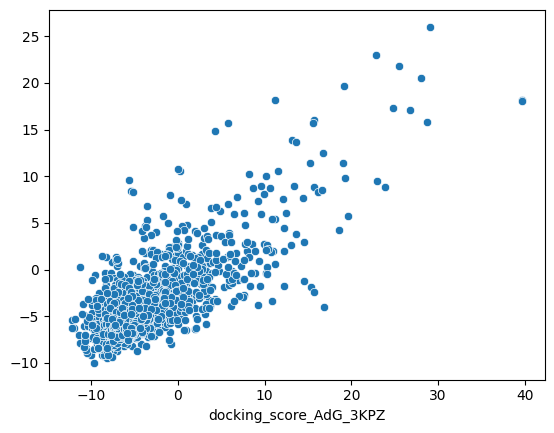

In [53]:
sns.scatterplot(x=y_test,y=y_pred)

## What are torsion FPS?

In [48]:
from rdkit.Chem.rdMolDescriptors import GetHashedTopologicalTorsionFingerprintAsBitVect

df_contains = df_confs[df_confs.id_conf.str.contains('VDRML13066')]
df_contains
conformers_fps = [GetHashedTopologicalTorsionFingerprintAsBitVect(mol) for mol in df_contains.ROMol]

print(conformers_fps[0] == conformers_fps[1])

# Calculate the Jaccard distance
jaccard_dist = 1.0 - np.sum(np.minimum(conformers_fps[0], conformers_fps[1])) / np.sum(np.maximum(conformers_fps[0], conformers_fps[1]))

print("Jaccard distance between the two arrays is:", jaccard_dist)

True
Jaccard distance between the two arrays is: 0.0
